In [4]:
from IPython.core.display import HTML as Center

Center(""" <style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style> """)

# Structured Product Engineering
### Vitalii Rudko \ June, 2021

In [3]:
#Importing packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from math import log, exp
from scipy.stats import norm
from numpy.random import normal

## Introduction 
Structured product is a portfolio of basic assets, such as stocks, bonds, currencies together with some derivatives. Structured products provide better returns with a strong credit quality, a low cost of asset-liability management, and the principal protection. The main motivation behind constructing such securities is following 

1. From the buyer perspective, the properties of structured products allow banks to circumvent capital requirements to be able to hold more risky assets on their balance sheets. Of course, it is all done under cover of the structured products which, as was said previously, have an enhanced credit quality;

2. From the seller side, structured products enables investment banks to make illiquid assets liquid and put the risk off the their balance by selling risky assets on the market through repackaging process; 

An important aspect of structuring is a principal protection mechanism, which assures that in the worst case scenario an investor receives back his invested principal at maturity. A classical approach is following

1. We take a long position in a zero-coupon bond with a maturity at $T$, a price $B_{zc}$ and notional $N$;
2. Now, we can invest $N - B_{zc}$ in some derivative instrument, preferably an option; 
3. Any residue should be put into deposit account; 
4. At the maturity we receive notional $N$ and a payoff of the option;

The strategy was developed in the 80s, when interest rates were much higher than now, so the difference between the bond's price and its notional was large enough to finance purchases of the options. This creates a problem, which potentially can be solved by: 

* decreasing the protected principal amount, which in turn increases the risk of the investment,  
* the construction of a self-financing portfolio, 
* the application of cheap derivatives. 

There are other more complex techniques that can be considered, such as the constant proportion portfolio adjustment (CPPI) or dynamic proportion portfolio adjustment (DPPI), but they will not be discussed in this project.   

## Strategy and Components
We are going to use a **52-week T-Bill** issued on **05/20/2021**, which also be a starting date for our structured product. Thus it matures on **05/19/2022**, therefore our product matures in one year, $T = 1$. It is also assumed in accordance with Black-Scholes framework, that the time structure of interest rates is flat, so the bond's yield is assumed to be a risk-free rate, $r = 0.056\%$. However, T-Bills are quoted on 30/360 basis, thus we should adjust our interest rate in order to get risk free rate quoted on actual/actual basis, so the risk fre rate is $\frac{365}{360} \times 0.056\% = 0.057\%$. Notice, that the price of the bond is **99.9444 USD** [1], which leaves us only with 6 cents to be invested in a risky asset. Thus we have to apply solutions described in the previous subsection. 

First of all, let $N$ be equal to **100 USD**. Then the guaranteed principal is reduced from $100\%$ to at least $85\%$. We will call it a floor and denote it as $F$. Further, we should consider investing our money into european cash-or-nothing digital options, since their payoff is known, so it is easier to manage the risks. So, in order to finance our venture we short the digital call on the S\&P 500 with a barrier $K_U = 5400$ and the coupon $C_U = 65$ **USD**. For the premium earned on the transaction, we can now take a long position in a digital call option for the same underlying asset, but with a lower barrier $K_L = 5300$ and a coupon $C_L = C_U - (1 - F) \times N$, which is **50 USD**. The remaining sum of money can be deposited in the bank. Eventually, this strategy produces the $15\%$ loss of the notional in the worst case scenario, and $C_L$ in the best case scenario, which is $50\%$ return on the notional.       

In [10]:
#The notional 
N = 100

#The bond's price
B = 99.9444

#The risk-free rate 
r = 0.057 / 100

#The upper barrier 
K_U = 5400

#The lower barrier 
K_L = 5300

#The upper coupon 
C_U = 65

#The lower coupon 
C_L = 50

#Duration
T = 1

### Historical Quotes of S&P500
It would be appropriate to introduce the plots of the S&P500 quotes and returns at this stage, as well as estimated parameters, which are used later on for the pricing. The plots are shown below. The data covers a one-year time window starting from the issue date of the bond. The last observed spot quote on 05/20/2021 after the close is $S_0 = 4115.68$. Also, the estimated annualized volatility is $v = 17\%$. 

In [11]:
#Importing data
sp500_df = yf.download('^GSPC', 
                      start = '2020-05-20', 
                      end = '2021-05-20', 
                      interval = "1d",
                      progress = False)

#Saving quotes in the separate variable
quotes = np.array(sp500_df["Close"])

#Calculating returns
returns = np.diff(np.log(quotes))

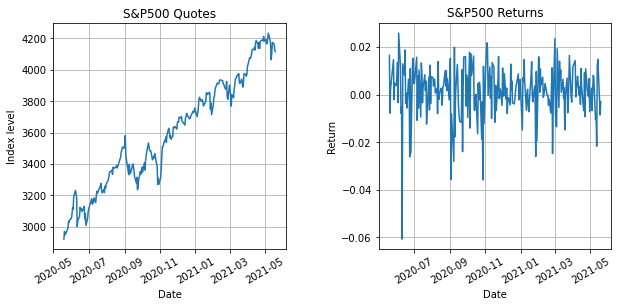

In [23]:
#Plotting S&P500 closing quotes and returns
#Figure parameters 
f1 = plt.figure(figsize=(10,10))
ax1 = f1.add_subplot(221)
ax2 = f1.add_subplot(222)

#Plotting quotes
ax1.plot(sp500_df.index, quotes)
#setting plot parameters;
ax1.set_title("S&P500 Quotes")
ax1.set_xlabel("Date")
ax1.set_ylabel("Index level")
ax1.tick_params(axis = "x", 
                labelrotation = 30)
ax1.grid()

#Plotting returns
ax2.plot(sp500_df.index[1:], returns)
#setting plot parameters;
ax2.set_title("S&P500 Returns")
ax2.set_xlabel("Date")
ax2.set_ylabel("Return")
ax2.tick_params(axis = "x", 
                labelrotation = 30)
ax2.grid()

plt.subplots_adjust(wspace = 0.4, hspace = 0.4)
plt.show()

In [13]:
#S0 - the initial price of underlying asset 
S0 = np.array(sp500_df["Close"])[-1]

#vol - volatility (annual)
v = np.std(returns) * 252**.5


## Payoff Function
The payoff of our structured product is dependent on the payoff of the digital options plus the notional, since the value of the notional is known, then it is necessary to define the payoff function of the cash-or-nothing call option first.

The payoff function of a european digital cash-or-nothing call option can expressed through the Heaviside function $\mathcal{H}(x)$:

\begin{equation}
DC_{\mathrm{payoff}} = C \times \mathcal{H}\left(S-K\right),
\end{equation}

where

\begin{equation}
\mathcal{H}(x):= \begin{cases}
1, & x>0 \\
0, & x\leq0
\end{cases}.
\end{equation}

So, the payoff function of the structured product is

\begin{equation}
SP_{\mathrm{payoff}} = N + C_L \times \mathcal{H}\left(S-K_L\right) - C_U \times \mathcal{H}\left(S-K_U\right),
\end{equation}

where $S$ is the spot price of the underlying security. The possible payoffs of the structured product for the range of index values $[4800, 6000]$ are shown in the plot below, given other assumptions are the same as was stated in the previous section 

In [1]:
#Defining functions 
def Heaviside(x):
    if x > 0:
        return 1
    else:
        return 0

def DCpayoff(C, S, K):
    return C * Heaviside(S - K)

def SPpayoff(N, S, C_L, K_L, C_U, K_U):
    return N + DCpayoff(C_L, S, K_L) - DCpayoff(C_U, S, K_U)

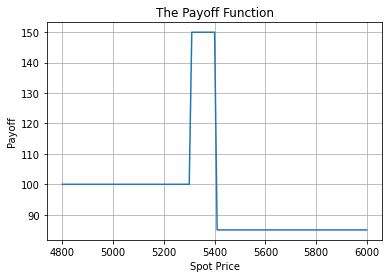

In [15]:
#Setting the range of index values 
S_range = np.arange(4800, 6001, 10)

#Calculating payoffs for various spot prices 
payoff_example = [SPpayoff(N, i, C_L, K_L, C_U, K_U) for i in S_range]
payoff_example = np.array(payoff_example)

#Plotting the function
plt.plot(S_range, payoff_example)
plt.title("The Payoff Function")
plt.xlabel("Spot Price")
plt.ylabel("Payoff")
plt.grid()

## Pricing 
Since we are applying replication strategy the price of our structured product will be just a negative of the sum of the all taken positions

\begin{equation}
	SP_{\mathrm{price}} = B + DC_L - DC_U,
\end{equation}

where $B$ is the price of the zero-coupon bond, $DC_L$ is the price of the cash-or-nothing call with the lower barrier, and $DC_U$ is the price of the cash-or-nothing call with the upper barrier. Since the price of the bond is given, it is only left to price options. Nevertheless, the formula of the bond's price will be useful later on, thus it is introduced below

\begin{equation}
B = \frac{N}{(1+r)^T}.
\end{equation}

Now we can move to the options. The analytical solution of the option price under Black-Scholes framework is the following: 

\begin{equation}
DC_{\mathrm{price}} =C \times \exp(-rT) \times N\left(d_{2}\right),
\end{equation}

where $N(x)$ is a cumulative distribution function of the standard normal distribution, and 

\begin{equation}
d_{2}=\frac{\log (S / K)+T\left(r-\frac{1}{2} v^{2}\right)}{v \sqrt{T}}.
\end{equation}

After plugging in all the parameters we obtain the following price 

In [16]:
def DC_BSM(S, K, C, r, v, T):
    d2 = (log(S / K) + (r - 0.5 * v**2) * T) / (v * T**0.5)
    return C * exp(-r*T) * norm.cdf(d2)

In [17]:
#The price of the lower call 
DC_L = DC_BSM(S0, K_L, C_L, r, v, T)

#The price of the upper call
DC_U = DC_BSM(S0, K_U, C_U, r, v, T)

#The price of the structured product 
SP = B + DC_L - DC_U

#Printing the output
output = "The price of the structured product is $" + str(round(SP, 2)) + "."
print("=" * len(output))
print(output)
print("=" * len(output))

The price of the structured product is $99.8.


Note, the price is below the notional, thus our strategy is working. The small difference between the price and the principal we can deposit in the bank account. 

## Sensitivity Analysis
The sensitivity of the structured product can be checked via greeks of underlying options. However, we also have a zero coupon bond, which value is also impacted either by any changes of the interest rate curve or maturity date. So, let us introduce the greeks for the options first [2][3]:

1) Delta is a partial derivative of the option price with the respect to the underlying asset price

\begin{align*}
\Delta &= \frac{\partial DC}{\partial S}, \\
       &= \exp(-rT) \times \frac{n(d_2)}{Sv\sqrt{T}}.
\end{align*}

2) Kappa is a partial derivative of the option price with the respect to the volatility parameter

\begin{align*}
K &= \frac{\partial DC}{\partial v}, \\
       &= -\exp(-rT) \times  \frac{d_1n(d_2)}{v}.
\end{align*}

3) Theta is a partial derivative of the option price with the respect to time

\begin{align*}
\Theta &= \frac{\partial DC}{\partial T}, \\
       &= r \exp(-r T) \times N\left(d_{2}\right)+\exp(-r T) \times  n\left(d_{2}\right) \times \left(\frac{d_{1}}{2 T}-\frac{r}{v \sqrt{T}}\right).
\end{align*}

4) Rho is a partial derivative of the option price with the respect to risk-free rate

\begin{align*}
P &= \frac{\partial DC}{\partial r}, \\
       &= -T \exp(-rT) \times (1 - N(d_2)) - \exp(-rT) \frac{\sqrt{T}}{v} \times n(d_2).
\end{align*}

In the obove equations $n(x)$ is the probability density function of the standard normal distribution, and 

\begin{equation}
d_{1}=\frac{\log (S / K)+\left(r+\frac{1}{2} v^{2}\right)T}{v \sqrt{T}}.
\end{equation} 

In order to complete the puzzle, we need to derive partial derivatives of the bond's price with respect to risk-free rate and time. The formulas are presented below

\begin{equation}
\frac{\partial B}{\partial T} = \frac{-N \ln (1+r)}{(1+r)^T},
\end{equation}

and

\begin{equation}
\frac{\partial B}{\partial r} = -T \times N \times (1+r)^{-T-1}.
\end{equation}

Now, we can explicitly define the partial derivatives of the structured product: 
\begin{equation}
\Delta_{SP} = \Delta_{DC_L} - \Delta_{DC_U},
\end{equation}

\begin{equation}
K_{SP} = K_{DC_L} - K_{DC_U},
\end{equation}

\begin{equation}
\Theta_{SP} = \frac{\partial B}{\partial T} + \Theta_{DC_L} - \Theta_{DC_U},
\end{equation}

\begin{equation}
P_{SP} = \frac{\partial B}{\partial r} + P_{DC_L} - P_{DC_U}.
\end{equation}

The plots of the price sensitivity with respect to the particular factors are presented below. Note, that the figures show a change of the price at a given point for the given constant change of the parameter, not the derivative itself. As we can see, the price of the structured product is negatively impacted by the increase of the spot price. Further, the low volatility is good for the price, and high volatility is vice versa. Also, time and interest rate changes have a negative impact on the price, however, this effect is linearly decreasing for the Rho function, and it has a convex shape for the Theta function.  

In [18]:
#Defining functions 
def Delta(S, K, r, v, T):
    d2 = (log(S / K) + (r - 0.5 * v**2) * T) / (v * T**0.5)
    return exp(-r * T) * (norm.pdf(d2) / S * v * T ** 0.5)

def Gamma(S, K, r, v, T):
    d1 = (log(S / K) + (r + 0.5 * v**2) * T) / (v * T**0.5)
    d2 = (log(S / K) + (r - 0.5 * v**2) * T) / (v * T**0.5)
    return exp(-r * T) * (d1 * norm.pdf(d2) / S**2 * v**2 * T)

def Kappa(S, K, r, v, T):
    d1 = (log(S / K) + (r + 0.5 * v**2) * T) / (v * T**0.5)
    d2 = (log(S / K) + (r - 0.5 * v**2) * T) / (v * T**0.5)
    return exp(-r * T) * (d1 * norm.pdf(d2) / v)

def Theta(S, K, r, v, T):
    d1 = (log(S / K) + (r + 0.5 * v**2) * T) / (v * T**0.5)
    d2 = (log(S / K) + (r - 0.5 * v**2) * T) / (v * T**0.5)
    return r * exp(-r * T) * norm.cdf(d2) + exp(-r * T) * norm.pdf(d2) * (d1 / (2 * T) - r / (v * T**0.5))

def Rho(S, K, r, v, T):
    d2 = (log(S / K) + (r - 0.5 * v**2) * T) / (v * T**0.5)
    return -T * exp(-r*T) * (1 - norm.cdf(d2)) - exp(-r * T) * T**0.5 / v * norm.pdf(d2)  

def dB_dt(N, r, T):
    return -N * log(1+r) / (1+r)**T

def dB_dr(N, r, T):
    return -N * T * (1 + r)**(-T-1)

In [19]:
#Creating ranges 
S_range = np.arange(4800, 6001, 10)
v_range = np.arange(0.01, 0.51, 0.01)
t_range = np.arange(1/365, T, 1/365)
r_range = np.arange(-0.05, 0.1, 0.001)

In [20]:
#Estimating greeks 
delta = np.array([Delta(i, K_L, r, v, T) - Delta(i, K_U, r, v, T) for i in S_range]) * 10
kappa = np.array([Kappa(S0, K_L, r, i, T) - Kappa(S0, K_U, r, i, T) for i in v_range]) * 0.01
theta = np.array([dB_dt(N, r, i) + Theta(S0, K_L, r, v, i) - Theta(S0, K_U, r, v, i) for i in t_range]) * 1/365
rho = np.array([dB_dr(N, i, T) + Rho(S0, K_L, i, v, T) - Rho(S0, K_U, i, v, T) for i in r_range]) * 0.001

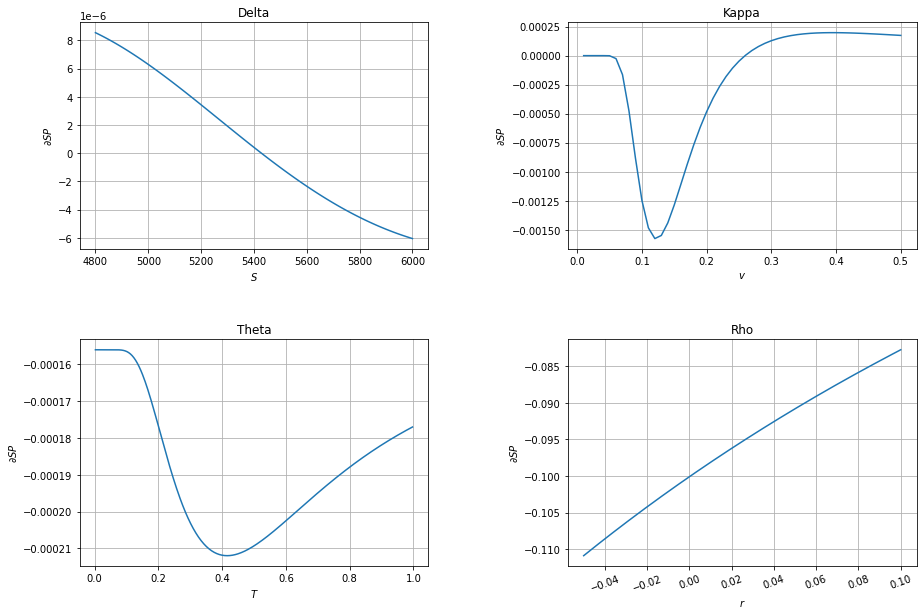

In [21]:
#Plotting simulated greeks
#Figure parameters 
f3 = plt.figure(figsize=(15,10))
ax1 = f3.add_subplot(221)
ax2 = f3.add_subplot(222)
ax3 = f3.add_subplot(223)
ax4 = f3.add_subplot(224)

#Plotting simulated levels
ax1.plot(S_range, delta)
#setting plot parameters;
ax1.set_title("Delta")
ax1.set_xlabel("$S$")
ax1.set_ylabel("$\partial SP$")
ax1.grid()

#Plotting simulated levels
ax2.plot(v_range, kappa)
#setting plot parameters;
ax2.set_title("Kappa")
ax2.set_xlabel("$v$")
ax2.set_ylabel("$\partial SP$")
ax2.grid()

#Plotting simulated levels
ax3.plot(t_range, theta)
#setting plot parameters;
ax3.set_title("Theta")
ax3.set_xlabel("$T$")
ax3.set_ylabel("$\partial SP$")
ax3.grid()

#Plotting simulated levels
ax4.plot(r_range, rho)
#setting plot parameters;
ax4.set_title("Rho")
ax4.set_xlabel("$r$")
ax4.set_ylabel("$\partial SP$")
ax4.tick_params(axis = "x", 
                labelrotation = 20)
ax4.grid()

plt.subplots_adjust(wspace = 0.4, hspace = 0.4)
plt.show()

## References
[1] Obtained from: 
https://www.treasurydirect.gov/instit/annceresult/annceresult.htm

[2] Bartkowiak, M (2021). Lecture materials.

[3] QuantPie. URL: https://quantpie.co.uk/bsm_bin_c_formula/bs_bin_c_summary.php